TrainData: M: 50000, N: 784.
TrainLABELS: M: 50000, N: 10.
Epoch # 1 
Epoch training loss: 0.834921
Epoch training accu: 0.844760
Epoch dev loss: 0.918270
Epoch dev accu: 0.837200
Epoch # 2 
Epoch training loss: 0.557492
Epoch training accu: 0.882000
Epoch dev loss: 0.681932
Epoch dev accu: 0.863800
Epoch # 3 
Epoch training loss: 0.442994
Epoch training accu: 0.899720
Epoch dev loss: 0.580280
Epoch dev accu: 0.876300
Epoch # 4 
Epoch training loss: 0.382435
Epoch training accu: 0.909440
Epoch dev loss: 0.522144
Epoch dev accu: 0.884600
Epoch # 5 
Epoch training loss: 0.344360
Epoch training accu: 0.916660
Epoch dev loss: 0.484653
Epoch dev accu: 0.889000
Epoch # 6 
Epoch training loss: 0.304917
Epoch training accu: 0.925980
Epoch dev loss: 0.445996
Epoch dev accu: 0.896100
Epoch # 7 
Epoch training loss: 0.284730
Epoch training accu: 0.929720
Epoch dev loss: 0.423593
Epoch dev accu: 0.900000
Epoch # 8 
Epoch training loss: 0.263256
Epoch training accu: 0.933660
Epoch dev loss: 0.40173

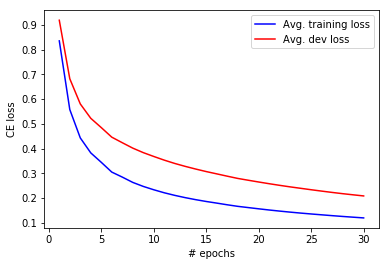

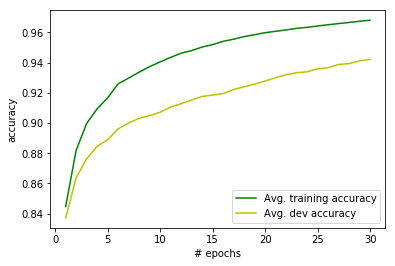

<Figure size 432x288 with 0 Axes>

In [137]:
# %load nn_starter.py
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
import time
import warnings

FIRST_RUN = False # whether/not to perform preprocessing
REGULARIZE = True # whether/not to add the regularization term to the W gradients

B = 1000 # minibatch size
N_HIDDEN = 300 # num hidden units
N_CLASSES = 10 # number of categories to classify into (the digits 0-9)
N_PIXELS = 784 # number of input pixels in each image (784 = 28^2)
N_EPOCHS = 30  # number of training epochs to run for
ALPHA = 5  # learning rate
# TODO LAMBDA = 0.0001
LAMBDA = 0.0001 # regularization factor
RANDOM_SEED = 100
EPSILON = 0.0001 # for numerical stability when normalizing gradient
NUM_ES_SAMPLES = 10
#ES_SHIFT_FACTOR = 0.01 # Defines variance of the random shift
ES_SHIFT_FACTOR = 1.25

# Enable/disable the hybrid evolution strategy algorithm
ALG_ON = True
# Compute the full gradient every this-many iterations (set to 1 to compute full grad every iteration)
FULL_GRAD_EVERY = 2

trainCosts = []
devCosts = []
trainAccuracies = []
devAccuracies = []

trainW1GradNorms = []
trainW2GradNorms = []
trainW1GradCosines = []
trainW2GradCosines = []

def readData(images_file, labels_file):
    x = np.loadtxt(images_file, delimiter=',')
    y = np.loadtxt(labels_file, delimiter=',')
    return x, y

# computes an element-wise softmax over the vector x
def softmax(x):
    """
    Compute softmax function for input. 
    Use tricks from previous assignment to avoid overflow
    """
    ### YOUR CODE HERE
    
    # trick to solve overflow - subtract the max from each element
    maxElem = np.max(x)
    shiftedX = np.subtract(x, maxElem)
    
    numerators = np.exp(shiftedX)
    denominator = np.sum(numerators, axis=0)
    # finally, perform elementwise division
    s = np.divide(numerators, denominator)

    ### END YOUR CODE
    return s

# computes the cross-entropy cost between y and yHat
# (NOT the gradient, the actual cost function)
def CE(y, yHat):
    # compute the dot product of y and yHat, with vectors as columns
    #vec = -np.tensordot(y, np.log(yHat), (0,0)).diagonal()
    vec = -np.einsum('ij,ij->j', y, np.log(yHat))
    s = np.sum(vec) / float(B)
    return s

# computes the scalar-valued Gradient of (Frobenius norm)^2 of a matrix
def GradFrobNormSquared(mat):
    s = np.sum(np.multiply(2, mat))
    s = LAMBDA * s
    return s

# computes an element-wise sigmoid over the single element x
# TODO also need trick to subtract the max from each element
def _stable_sigmoid(x):
    """
    Compute the sigmoid function for the input here.
    """
    ### YOUR CODE HERE
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            if x >= 0:
                z = np.exp(-x)
                s = 1 / (1 + z)
            else:
                z = np.exp(x)
                s = z / (1 + z)
                
        except Warning as e:
            print('NumPy error:', e)

    ### END YOUR CODE
    return s

# computes an element-wise sigmoid over the MATRIX x
def _sigmoid(x):
    #vSigmoid = np.vectorize(_sigmoid)
    #return vSigmoid(x)
    
    return 1 / (1 + np.exp(-x))

def sigmoid(x):
    return expit(x)
    
# compute forward prop output and CE loss for a batch
# TODO make sure using data (batch data).T
# and labels.T
def forward_prop(data, labels, params):
    """
    return hidden layer, output(softmax) layer and loss
    """
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    ### YOUR CODE HERE
    
    z1 = np.add(np.matmul(W1, data.T), b1)
    a1 = h = sigmoid(z1)
    z2 = np.add(np.matmul(W2, a1), b2)
    a2 = yHat = softmax(z2)
    cost = CE(labels.T, yHat)

    ### END YOUR CODE
    
    # (output of 1st layer, output of 2nd layer, J)
    return h, yHat, cost

# compute gradient updates to parameters for a batch
def backward_prop(data, labels, params, h, yHat, cost):
    """
    return gradient of parameters
    """
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    ### YOUR CODE HERE
    
    delta2 = np.subtract(yHat, labels.T)
     
    sigmoidPrime = np.multiply(h, np.subtract(1, h))
    delta1 = np.multiply(np.matmul(W2.T, delta2), sigmoidPrime)
    
    gradW1 = np.matmul(delta1, data)  # double transpose cancels
    gradW2 = np.matmul(delta2, h.T)
    gradb1 = delta1
    gradb2 = delta2

    ### END YOUR CODE

    grad = {}
    grad['W1'] = gradW1
    grad['W2'] = gradW2
    grad['b1'] = gradb1
    grad['b2'] = gradb2

    return grad

def f_prop_over_batch(i, data, labels, params):
    dataBatch = data[B*i:B*(i+1),:]
    labelsBatch = labels[B*i:B*(i+1),:]
    
    h, yHat, cost = forward_prop(dataBatch, labelsBatch, params)
    
    return h, yHat, cost

# calculate the cosine of the angle between two vectors
def cosine(a, b):
    return np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b))

def nn_train(trainData, trainLabels, devData, devLabels):
    (m, n) = trainData.shape

    # MOD:
    print("TrainData: M: %d, N: %d." % (m,n))
    print("TrainLABELS: M: %d, N: %d." % trainLabels.shape)

    params = {}

    ### YOUR CODE HERE

    # initialize the parameters
    params['W1'] = np.random.standard_normal((N_HIDDEN, N_PIXELS))
    params['W2'] = np.random.standard_normal((N_CLASSES, N_HIDDEN))
    params['b1'] = np.zeros((N_HIDDEN, B))
    params['b2'] = np.zeros((N_CLASSES, B))

    # TODO run for 30 epochs
    prevW1GradNorm = 0
    prevW2GradNorm = 0
    prevAvgdW1 = np.ones(N_HIDDEN*N_PIXELS)    # TODO watch out for divide-by-0 here
    prevAvgdW2 = np.ones(N_CLASSES*N_HIDDEN)
    
    grad = None # MOD: namespacing
    for i in range(N_EPOCHS):
        print('\033[1;31mEpoch #', i+1, '\033[0;0m')    # red color to make it pop
        
        epochdW1 = epochdW2 = None
        
        # TODO try putting the stochastic tweak code as an argmax out here
        
        # Training loop
        for j in range(50):
            #print("Beginning epoch iteration # %d" % j)
            trainDataBatch = trainData[B*j:B*(j+1),:]
            trainLabelsBatch = trainLabels[B*j:B*(j+1),:]

            #start_time = time.time()
            h, yHat, cost = forward_prop(trainDataBatch, trainLabelsBatch, params)
            #print("Forward prop took %f secs" % (time.time() - start_time))
            # MOD: only update gradient for certain epochs (see FULL_GRAD_EVERY)
            didFullGrad = False
            if (not ALG_ON or j % FULL_GRAD_EVERY == 0):
            #if (not ALG_ON or i < 10):
                #start_time = time.time()
                grad = backward_prop(trainDataBatch, trainLabelsBatch, params, h, yHat, cost)
                #print("Backprop took %f secs" % (time.time() - start_time))
                didFullGrad = True
            # dW1 shape: (300, 784)
            # print the weight of the first pixel into the first HU
            #print("dW1[0][0]" + str(grad['W1'][0][0]))
            
            # TODO put gradient checking in here
            #print("-"*40)
            dW1 = dW1_orig = grad["W1"]
            dW2 = dW2_orig = grad["W2"]
            #dW1 = dW1 / float(B)    # scale by batch size
            #dW2 = dW2 / float(B)
            #print(dW1.shape)
            #print(dW2.shape)
            
            '''
            dW1Norms = np.linalg.norm(dW1, axis=1, keepdims=True)
            dW2Norms = np.linalg.norm(dW2, axis=1, keepdims=True)
            
            # For dW1
            newMeanNorm = np.mean(dW1Norms)
            deltaNorm = np.absolute(prevW1GradNorm - newMeanNorm)
            prevW1GradNorm = newMeanNorm
            trainW1GradNorms.append(deltaNorm)
            
            # and now for dW2
            newMeanNorm = np.mean(dW2Norms)
            deltaNorm = np.absolute(prevW2GradNorm - newMeanNorm)
            prevW2GradNorm = newMeanNorm
            trainW2GradNorms.append(deltaNorm)
            
            # Now, cosine similarity
            avgdW1 = dW1.flatten()
            avgdW2 = dW2.flatten()
            
            trainW1GradCosines.append(np.arccos(cosine(avgdW1, prevAvgdW1)))
            prevAvgdW1 = avgdW1
            trainW2GradCosines.append(np.arccos(cosine(avgdW2, prevAvgdW2)))
            prevAvgdW2 = avgdW2
            '''

            # update W <- W - alpha(grad) and same for b
            gradScale = ALPHA / float(B) # don't forget to scale the gradient by batch size!

            
            # Cache these out here to keep them consistent across H-ES runs
            # (we only want dW1 and dW2 to change, not W1 and W2)
            W1 = W1_orig = params['W1']
            W2 = W2_orig = params['W2']
            
            # MOD:
            # Randomly perturb the gradient NUM_ES_SAMPLES times,
            # and pick the one that gives the lowest forward-prop cost
            bestStochCost = float('inf')
            stochdW1 = stochdW2 = None
            devStochdW1 = devStochdW2 = None
            foundBetterStoch = False
            tmpParams = [] # namespacing
            if ALG_ON and not didFullGrad:
                for k in range(NUM_ES_SAMPLES):
                    #start_time = time.time()
                    randdW1 = ES_SHIFT_FACTOR * np.random.randn(*dW1.shape)
                    randdW2 = ES_SHIFT_FACTOR * np.random.randn(*dW2.shape)
                    tmpdW1 = dW1_orig + randdW1
                    tmpdW2 = dW2_orig + randdW2
                    #print("Rand shift took %f secs" % (time.time() - start_time))
                    
                    tmpW1 = W1_orig - ( gradScale*tmpdW1 + 2*ALPHA*LAMBDA*W1_orig )
                    tmpW2 = W2_orig - ( gradScale*tmpdW2 + 2*ALPHA*LAMBDA*W2_orig )
                    
                    # See if the random perturbation is actually better
                    # Just evaluate on the training set here. Should really use dev set.
                    tmpParams = {'W1': tmpW1, 'W2': tmpW2, 'b1': params['b1'], 'b2': params['b2']}
                    
                    # TODO here, evaulate it over the WHOLE DEV SET?
                    # 1.) Only take the kth update if it outperforms cost across the *entire* dev set
                    # 2.) Only take update if it averages an improvement across the entire dev set
                    # * Write these out!
                    
                    _h, _yHat, _cost = forward_prop(trainDataBatch, trainLabelsBatch, tmpParams)
                    if (_cost < cost and _cost < bestStochCost):
                        bestStochCost = _cost
                        #print("FBS: true; %f vs. %f (%i, %i, %i)" % (bestStochCost, cost, i, j, k))
                        foundBetterStoch = True
                        stochdW1 = tmpdW1
                        stochdW2 = tmpdW2
                        
                        
                # MOD: actually commit the perturbed gradients IF they're better than reference
                # TODO DEBUG: update in the grads[] dict too?
                # TODO here, evaulate it over the WHOLE DEV SET?
                # TODO DEBUG
                # if (bestStochCost < cost):
                '''
                numStochBetter = 0
                for j in range(10):
                    devDataBatch = devData[B*j:B*(j+1),:]
                    devLabelsBatch = devLabels[B*j:B*(j+1),:]
            
                    __h, __yHat, __cost = forward_prop(devDataBatch, devLabelsBatch, tmpParams)
                    if (__cost < cost):
                        numStochBetter += 1
                        #print("Stochastic better on one round of dev set")
                    print("For this j, stoch was better %d out of 10 times." % numStochBetter)
                
              
                    print("Stochastic gradient was better than the unmodified gradient (%f vs %f)." % (bestStochCost, cost))
                    dW1 = stochdW1
                    dW2 = stochdW2
                    foundBetterStoch = True
                '''                

            # Actually update the parameters based on the best gradient we found
            # TODO DEBUG MOD: only update if we found some better stuff with Stochastic method
            # (Otherwise, do nothing!)
            # (Only update if better AND i % 2 == 0, etc.?)
            if (didFullGrad or foundBetterStoch):
                if REGULARIZE:
                    #start_time = time.time()
                    params['W1'] = W1 - ( gradScale*dW1 + 2*ALPHA*LAMBDA*W1 )
                    params['W2'] = W2 - ( gradScale*dW2 + 2*ALPHA*LAMBDA*W2 )
                    #print("Parameter updates took %f secs" % (time.time() - start_time))
                else:
                    params['W1'] = W1 - gradScale*dW1
                    params['W2'] = W2 - gradScale*dW2
            
            # Only mess with the W gradients, not b
            params['b1'] = params['b1'] - gradScale*grad['b1']
            params['b2'] = params['b2'] - gradScale*grad['b2']


        # Training set eval loop
        tCosts = []
        tAccuracies = []
        for j in range(50):
            trainDataBatch = trainData[B*j:B*(j+1),:]
            trainLabelsBatch = trainLabels[B*j:B*(j+1),:]

            h, yHat, cost = forward_prop(trainDataBatch, trainLabelsBatch, params)
            tCosts.append(cost)
            tAccuracies.append(compute_accuracy(yHat.T, trainLabelsBatch))
            
        epochTrainCost = np.mean(tCosts)
        epochTrainAccu = np.mean(tAccuracies)
        trainCosts.append(epochTrainCost)
        trainAccuracies.append(epochTrainAccu)
        print("Epoch training loss: %f" % epochTrainCost)
        print("Epoch training accu: %f" % epochTrainAccu)
            
        # calculate loss and accuracy over the dev set as well
        dCosts = []
        dAccuracies = []
        for j in range(10):
            devDataBatch = devData[B*j:B*(j+1),:]
            devLabelsBatch = devLabels[B*j:B*(j+1),:]
            
            h, yHat, cost = forward_prop(devDataBatch, devLabelsBatch, params)
            dCosts.append(cost)
            dAccuracies.append(compute_accuracy(yHat.T, devLabelsBatch))
            
        epochDevCost = np.mean(dCosts)
        epochDevAccu = np.mean(dAccuracies)
        devCosts.append(epochDevCost)
        devAccuracies.append(epochDevAccu)
        print("Epoch dev loss: %f" % epochDevCost)
        print("Epoch dev accu: %f" % epochDevAccu)

    # save the parameters
    np.save('data/params.npy', params)
    ### END YOUR CODE

    return params

def nn_test(data, labels, params):
    tAccuracies = []
    for j in range(10):
        h, yHat, cost = f_prop_over_batch(j, data, labels, params)
        labelsBatch = labels[B*j:B*(j+1),:]
        tAccuracies.append(compute_accuracy(yHat.T, labelsBatch))
    accuracy = np.mean(tAccuracies)
    
    return accuracy

def compute_accuracy(output, labels):
    accuracy = (np.argmax(output,axis=1) == np.argmax(labels,axis=1)).sum() * 1. / labels.shape[0]
    return accuracy

def one_hot_labels(labels):
    one_hot_labels = np.zeros((labels.size, 10))
    one_hot_labels[np.arange(labels.size),labels.astype(int)] = 1
    return one_hot_labels

# plot the train/dev set loss/accuracies vs. 30 epochs
def plotTrainDev():
    x = range(1, N_EPOCHS+1)
    # plot the losses
    plt.plot(x, trainCosts, 'b-', label='Avg. training loss')
    plt.plot(x, devCosts, 'r-', label='Avg. dev loss')
    plt.xlabel('# epochs')
    plt.ylabel('CE loss')
    plt.legend()
    plt.show()
    plt.clf()
    
    # plot the accuracies
    plt.plot(x, trainAccuracies, 'g-', label='Avg. training accuracy')
    plt.plot(x, devAccuracies, 'y-', label='Avg. dev accuracy')
    plt.xlabel('# epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    plt.clf()
    
    '''
    # plot the ITERATION-to-ITERATION gradient changes
    x2 = range(50*N_EPOCHS)
    plt.plot(x2, trainW1GradNorms, '-', color='orange', label='Avg. training W1 gradient norm difference')
    plt.plot(x2, trainW2GradNorms, '-', color='maroon', label='Avg. training W2 gradient norm difference')
    plt.xlabel('# iterations')
    plt.ylabel('∆norm')
    plt.legend()
    plt.show()
    plt.clf()
    
    # plot the ITERATION-to-ITERATION cosine distance
    plt.plot(x2, trainW1GradCosines, '-', color='orange', label='Training W1 gradient')
    plt.plot(x2, trainW2GradCosines, '-', color='maroon', label='Training W2 gradient')
    plt.xlabel('# iterations')
    plt.ylabel('Angle (radians) from previous gradient')    # TODO stop looking at the average across all HUs (bad!)
    plt.legend()
    plt.show()
    plt.clf()
    '''


def main():
    np.random.seed(RANDOM_SEED)
    
    if FIRST_RUN:
        trainData, trainLabels = readData('data/images_train.csv', 'data/labels_train.csv')
        trainLabels = one_hot_labels(trainLabels)
        p = np.random.permutation(60000)
        trainData = trainData[p,:]
        trainLabels = trainLabels[p,:]

        devData = trainData[0:10000,:]
        devLabels = trainLabels[0:10000,:]
        trainData = trainData[10000:,:]
        trainLabels = trainLabels[10000:,:]

        mean = np.mean(trainData)
        std = np.std(trainData)
        trainData = (trainData - mean) / std
        devData = (devData - mean) / std

        testData, testLabels = readData('data/images_test.csv', 'data/labels_test.csv')
        testLabels = one_hot_labels(testLabels)
        testData = (testData - mean) / std

        np.save('data/trainLabels.npy', trainLabels)
        np.save('data/devData.npy', devData)
        np.save('data/devLabels.npy', devLabels)
        np.save('data/testData.npy', testData)
        np.save('data/testLabels.npy', testLabels)
    
    else:
        trainData = np.load('data/trainData.npy')
        trainLabels = np.load('data/trainLabels.npy')
        devData = np.load('data/devData.npy')
        devLabels = np.load('data/devLabels.npy')
        testData = np.load('data/testData.npy')
        testLabels = np.load('data/testLabels.npy')
    
    readyForTesting = False
    
    if not readyForTesting:
        params = nn_train(trainData, trainLabels, devData, devLabels)
        plotTrainDev()

    else:
        params = np.load('data/params.npy').item()
        accuracy = nn_test(testData, testLabels, params)
        print('-'*40)
        print('Test accuracy: %f' % accuracy)

if __name__ == '__main__':
    main()
